In [ ]:
# 2. 정규표현식으로 해시태그를 제거해서 전처리 하는 것 보단 해시태그를 이용한 분석을 하는 것도 좋다고 생각함

In [75]:
import os
import re
import platform

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

from tqdm import tqdm
from collections import Counter
import swifter
from konlpy.tag import Kkma, Komoran, Okt, Mecab
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

In [2]:
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
def Fontmanager():

    plt.rcParams['axes.unicode_minus'] = False

    if platform.system() == 'Windows':
        path = "c:/Windows/Fonts/malgun.ttf"
        font_name = font_manager.FontProperties(fname=path).get_name()
        rc('font', family=font_name)
    elif platform.system() == 'Darwin':
        path = '/Library/Fonts/Arial Unicode.ttf'
        font_name = font_manager.FontProperties(fname=path).get_name()
        rc('font', family='AppleGothic')
    elif platform.system() == 'Linux':
        path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
        font_name = font_manager.FontProperties(fname=path).get_name()
        rc('font', family='NanumBarunGothic')
    else:
        print('Unknown system... sorry~~~~~~')
    print(f"해당 pc의 운영 체제는 {platform.system()}이며 {font_name}로 설정되었습니다")  
    return path

In [4]:
path = Fontmanager()

해당 pc의 운영 체제는 Darwin이며 Arial Unicode MS로 설정되었습니다


In [5]:
election = pd.read_csv('dataset/election.csv')
election = election.drop_duplicates()

In [6]:
women_policy = pd.read_csv('dataset/women_policy.csv')
# 혹시 모를 중복제거
women_policy = women_policy.drop_duplicates()

In [7]:
# 혹시 모를 nan값 확인
women_policy.isna().sum()

datetime    0
id          0
text        0
username    0
dtype: int64

In [8]:
texts = women_policy[women_policy['text'].apply(lambda x : x.startswith('#'))]

In [9]:
texts['text'] = texts['text'].str.split('\n').apply(lambda x : [i for i in x if i.startswith('#') ])
texts['text'] = texts['text'].apply(lambda x: ' '.join(x))
texts['text'] = texts['text'].str.split(' ').apply(lambda x : [i for i in x if i.startswith('#') ])

<ipython-input-9-6b3ef2c31a36>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texts['text'] = texts['text'].str.split('\n').apply(lambda x : [i for i in x if i.startswith('#') ])
<ipython-input-9-6b3ef2c31a36>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texts['text'] = texts['text'].apply(lambda x: ' '.join(x))
<ipython-input-9-6b3ef2c31a36>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [10]:
word_of_Bag = sum(texts['text'], [])

No handles with labels found to put in legend.


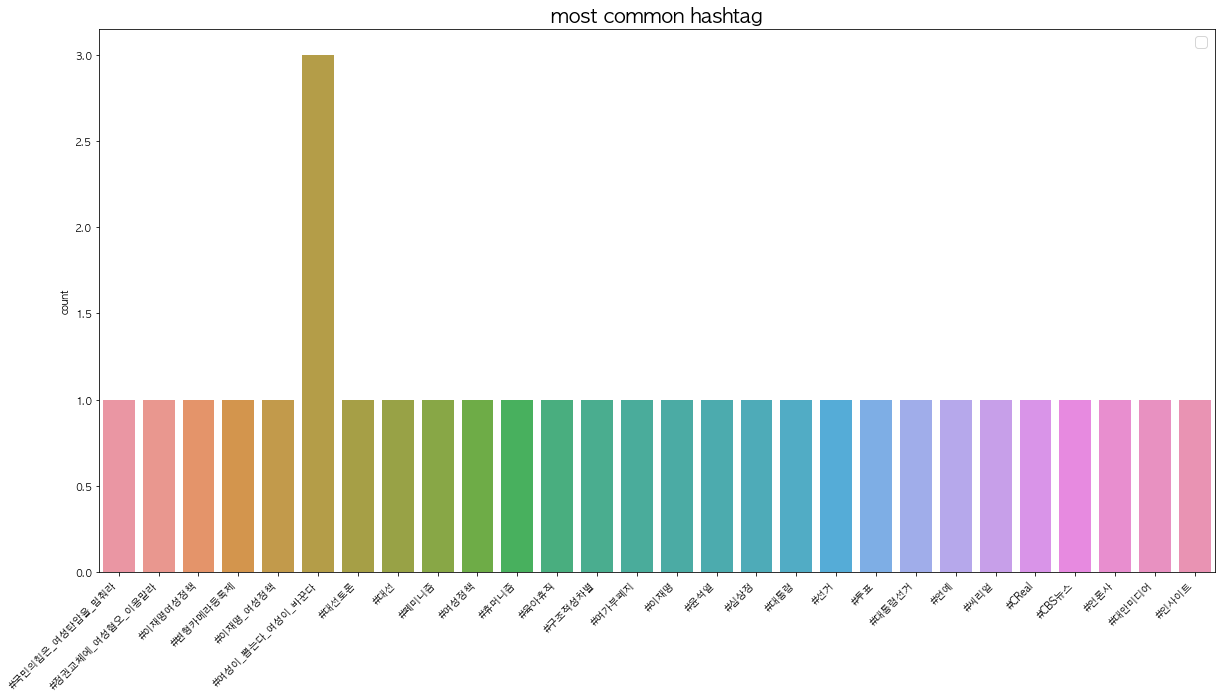

In [11]:
# 해시태그
plt.figure(figsize=(20,10))
plot = sns.countplot(word_of_Bag)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('most common hashtag', fontsize=20)
plt.legend(fontsize=15)
# save_fig('most common hashtag')

In [12]:
# 정규표현식 이용한 전처리
def clean(text):
    #\n 공백 제거
    text = re.sub('\n',' ',str(text))
    # URL 제거
    text = re.sub('https://[A-Za-z0-9./]*','',str(text))
    # 한글자 제거 (ex:ㅋㅋ, ㅜㅜ)
    text = re.sub('([ㄱ-ㅎㅏ-ㅣ])+', '', str(text))
    # 숫자 제거 (숫자 + 숫자만 제거, ex: 1인가족)
    text= re.sub('[0-9]{2}', '', str(text))
    # @알파벳 제거 
    text = re.sub('@[A-Za-z0-9./]*','',str(text))
    return str(text)

In [13]:
women_policy['text'] = women_policy['text'].apply(lambda x : clean(x))

그림 저장: Top 20 who the most writes


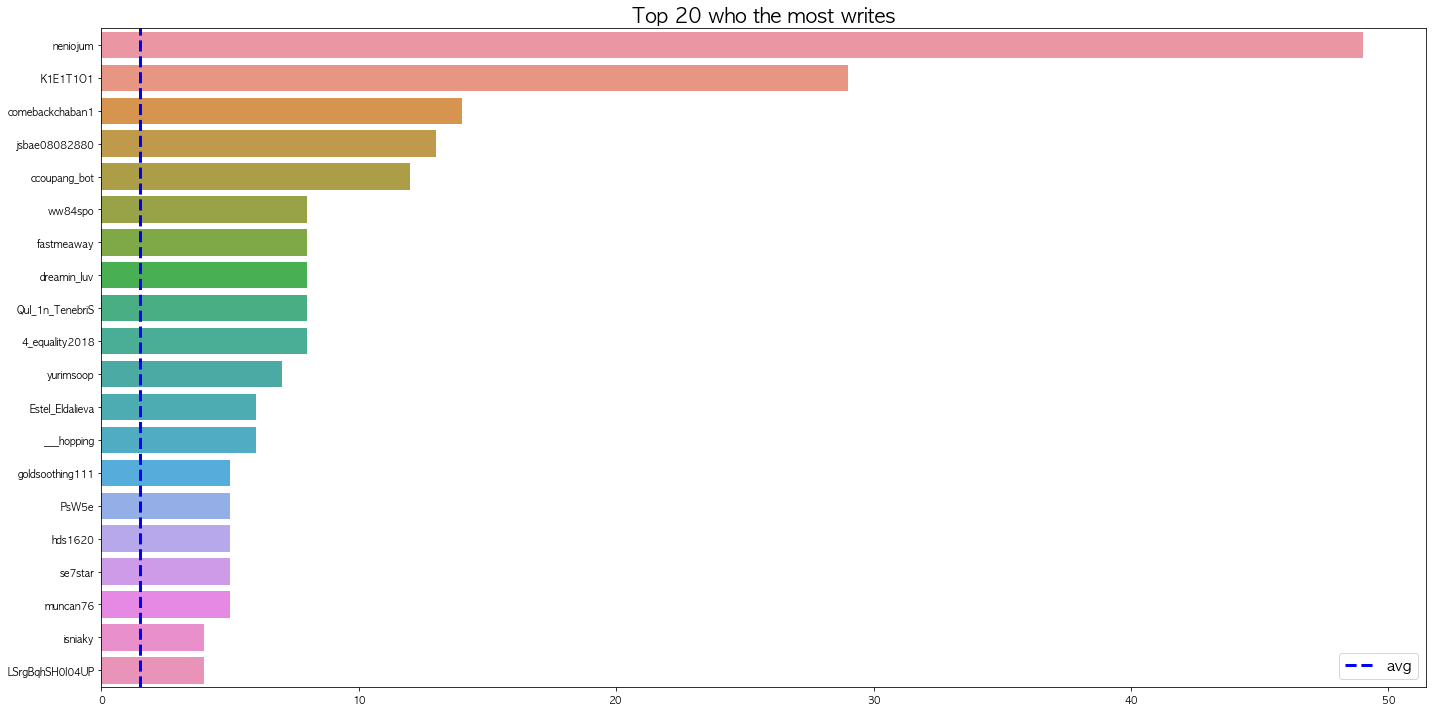

In [16]:
# 어떤 유저가 가장 많이 트윗을 썻는지
plt.figure(figsize=(20,10))
sns.barplot(x=women_policy['username'].value_counts()[:20].values, 
            y=women_policy['username'].value_counts()[:20].index,
           orient='h')
plt.title('Top 20 who the most writes', fontsize=20)
plt.axvline(x=np.average(women_policy['username'].value_counts().values), color='b', linestyle='--', linewidth=3, 
            label='avg')
plt.legend(fontsize=15)
save_fig('Top 20 who the most writes')

그림 저장: text length distribution


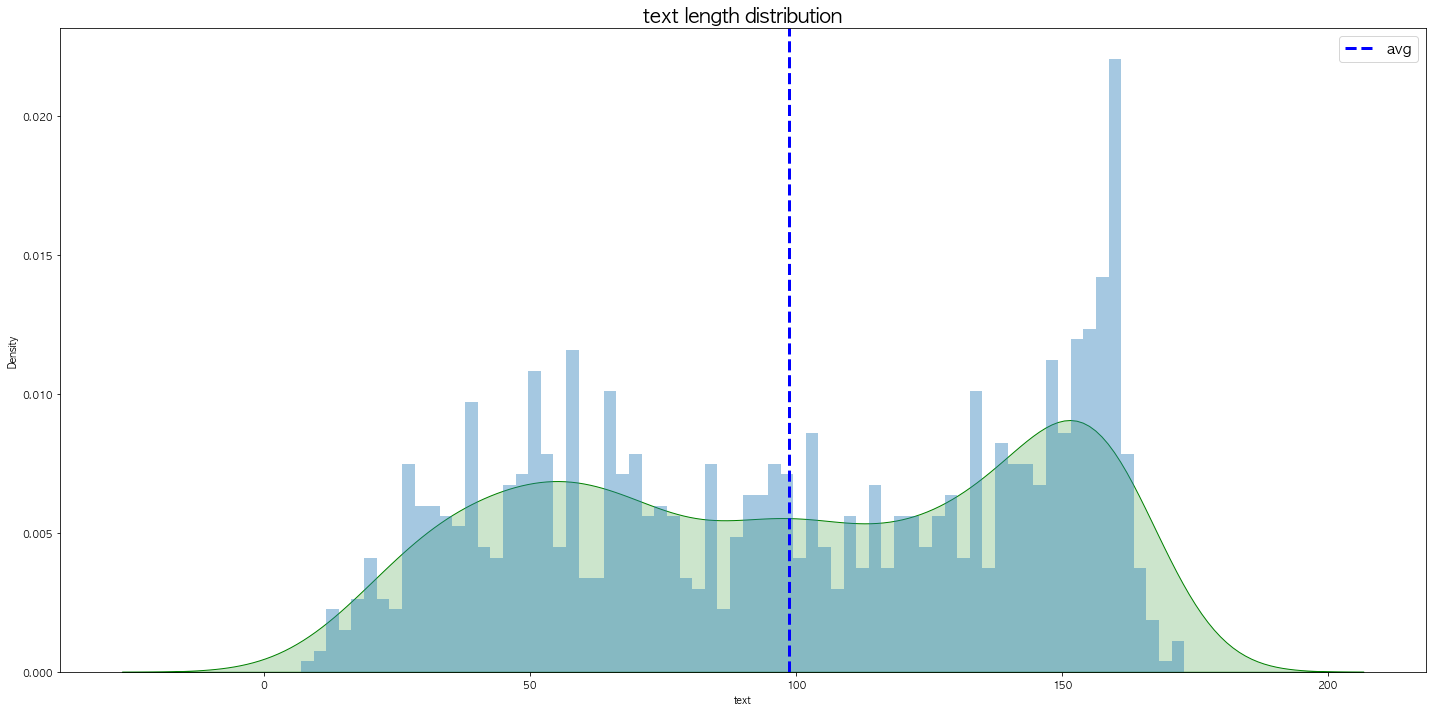

In [17]:
# 전체 문장 길이 분포
plt.figure(figsize=(20,10))
sns.distplot(a=women_policy['text'].str.len(), bins=70, kde=True,
             kde_kws={"color":"g", "alpha":0.2, "linewidth":1, "shade":True})
plt.title('text length distribution', fontsize=20)
plt.axvline(x=np.average(women_policy['text'].str.len()), color='b', linestyle='--', linewidth=3, 
            label='avg')
plt.legend(fontsize=15)
save_fig('text length distribution')

In [18]:
# tokenizer
kkma = Kkma()
komoran = Komoran()
okt = Okt()
mecab = Mecab()

# stopwords list
stop_words = pd.read_csv('dataset/한국어불용어100.txt', sep = "\t", engine='python')
stop_words = list(stop_words["word"])

In [19]:
def common_words(words, k):
    c = Counter(words)
    cw = c.most_common(k)
    return c, cw

In [20]:
def tokenizing(df, tokenizer):
    nouns = df.swifter.apply(lambda x : tokenizer.nouns(x))
    nouns_list = np.concatenate(nouns.tolist()).tolist()
    words = [n for n in nouns_list if len(n) > 1] 
    return nouns_list, words

In [21]:
def stopwords(words, stop_words):
    words_new = []

    for word in words:
        if word not in stop_words:
            words_new.append(word)
    return words_new

In [22]:
def wordcloud(c):
    wc = WordCloud(font_path='Arial Unicode', width=2000, height=1200, background_color ='white', scale=2.0, max_font_size=250)
    gen = wc.generate_from_frequencies(c)
    plt.figure(figsize = (12, 6), facecolor = None) 
    plt.imshow(gen)
    plt.axis("off")
    plt.tight_layout(pad=0)
    # save_fig("most_common_words_wordcloud")

Pandas Apply:   0%|          | 0/1128 [00:00<?, ?it/s]

그림 저장: wordcloud


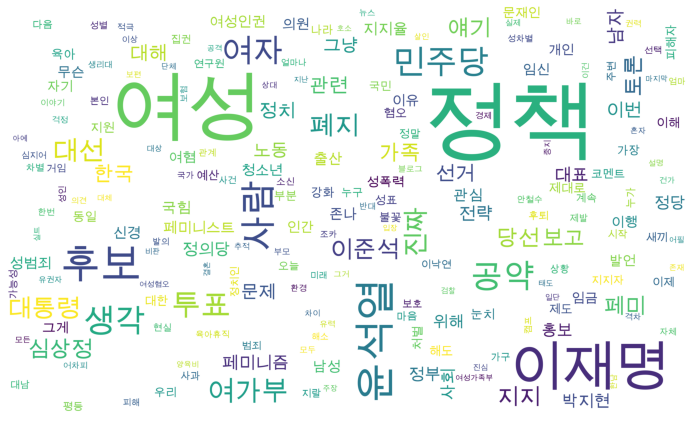

In [23]:
# wordcloud
nouns_list, words = tokenizing(women_policy['text'], okt)
words_new = stopwords(words, stop_words)
c, cw = common_words(words_new, 200)
wordcloud(c)
save_fig('wordcloud')

In [24]:
# 단어 길이 분포
nouns = women_policy['text'].swifter.apply(lambda x : okt.nouns(x))

Pandas Apply:   0%|          | 0/1128 [00:00<?, ?it/s]

그림 저장: word length distribution


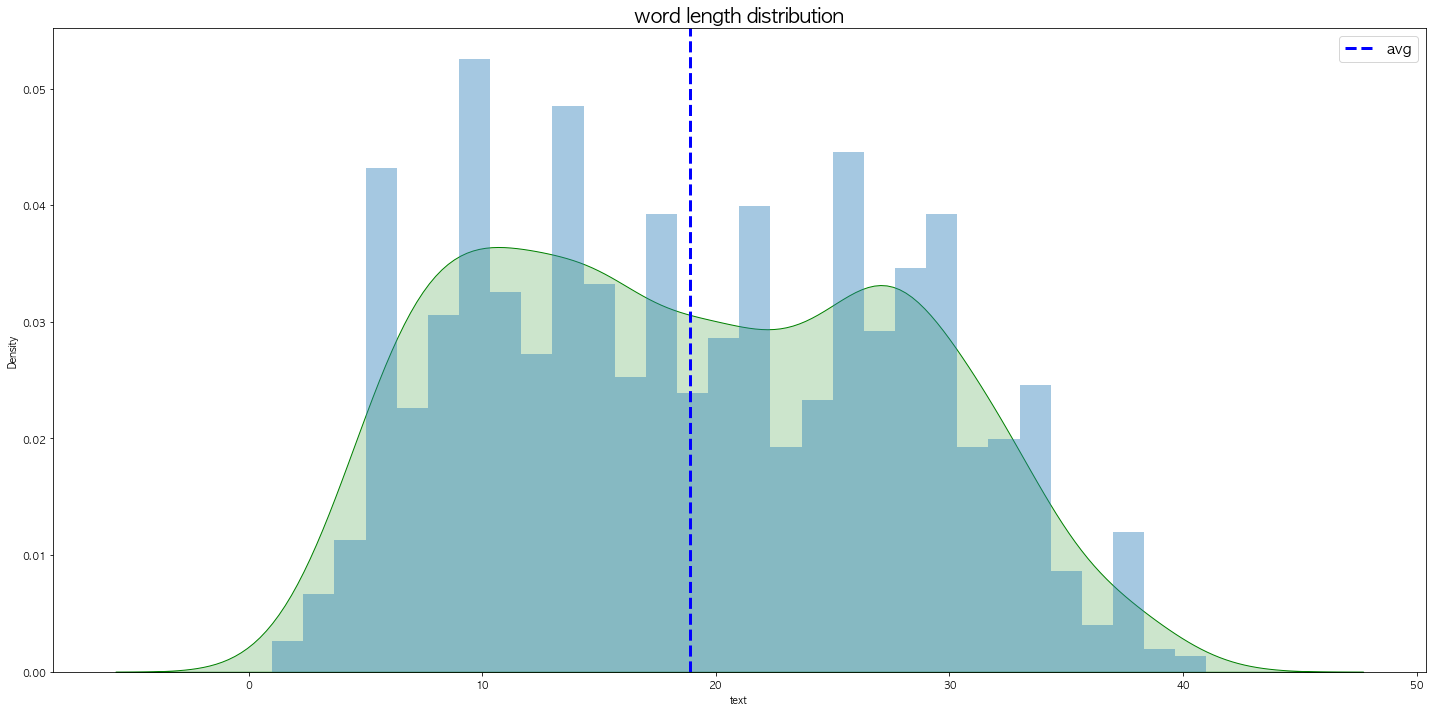

In [25]:
plt.figure(figsize=(20,10))
sns.distplot(a=nouns.str.len(), bins=30, kde=True,
             kde_kws={"color":"g", "alpha":0.2, "linewidth":1, "shade":True})
plt.title('word length distribution', fontsize=20)
plt.axvline(x=nouns.str.len().mean(), color='b', linestyle='--', linewidth=3, 
            label='avg')
plt.legend(fontsize=15)
save_fig('word length distribution')

In [26]:
# stopword 단어 분포

def stopwords(words, stop_words):
    words_new = []

    for word in words:
        if word in stop_words:
            words_new.append(word)
    return words_new

In [27]:
# 불용어 사전에 '여자' 등의 단어가 포함되어 있어서 뺐음

In [28]:
words_new = stopwords(words, stop_words)

No handles with labels found to put in legend.


그림 저장: stopword distribution


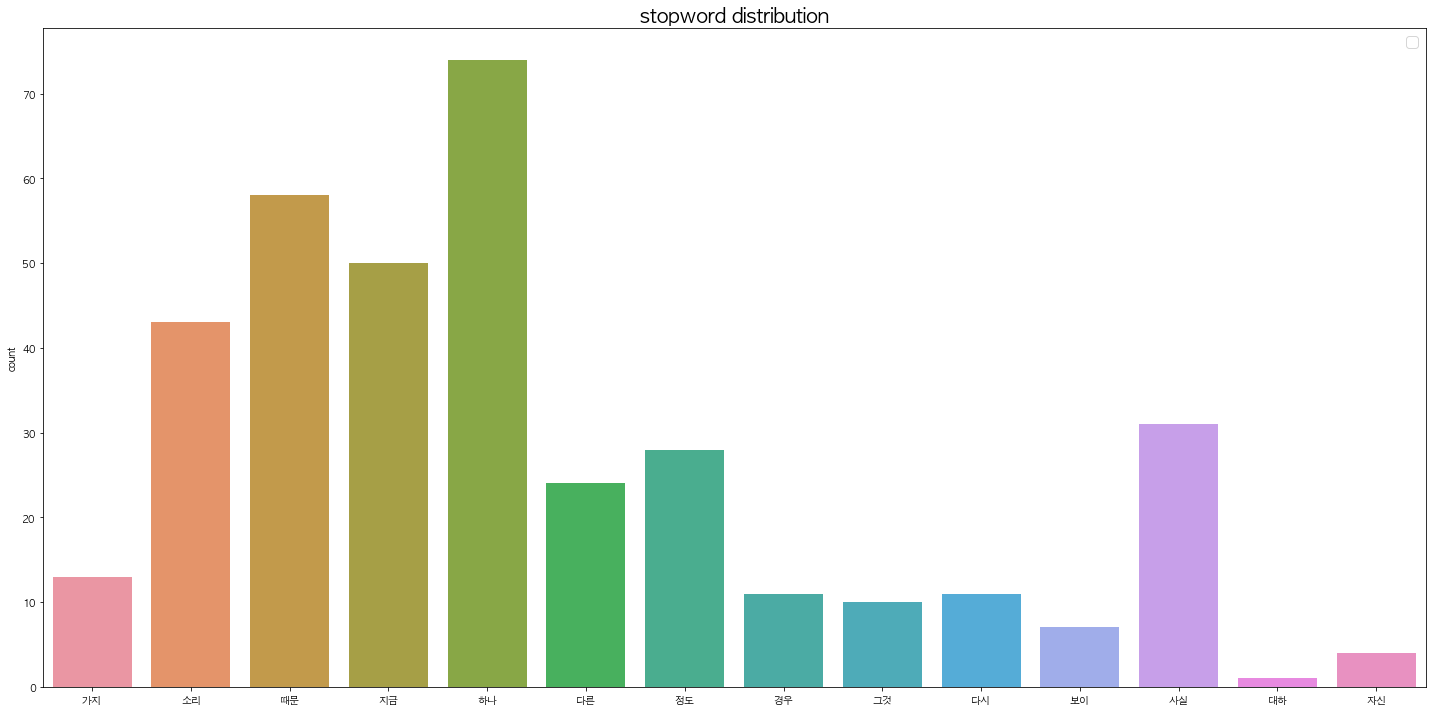

In [29]:
plt.figure(figsize=(20,10))
sns.countplot(words_new)
plt.title('stopword distribution', fontsize=20)
plt.legend(fontsize=15)
save_fig('stopword distribution')

In [30]:
# ngram exploration
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

In [31]:
new = women_policy['text'].str.split()
new = new.values.tolist()

In [32]:
words = [n for n in new if len(n) > 1] 

In [33]:
corpus = sum(words, [])

In [34]:
vec = CountVectorizer(ngram_range=(2,2)).fit(corpus)

In [35]:
bag_of_words = vec.transform(corpus)

In [36]:
sum_words = bag_of_words.sum(axis=0) 

In [37]:
words_freq = [(word, sum_words[0, idx])  for word, idx in vec.vocabulary_.items()]

In [38]:
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

In [39]:
top_n_bigrams = words_freq[:10]

In [40]:
x,y=map(list,zip(*top_n_bigrams))

No handles with labels found to put in legend.


그림 저장: ngram exploration


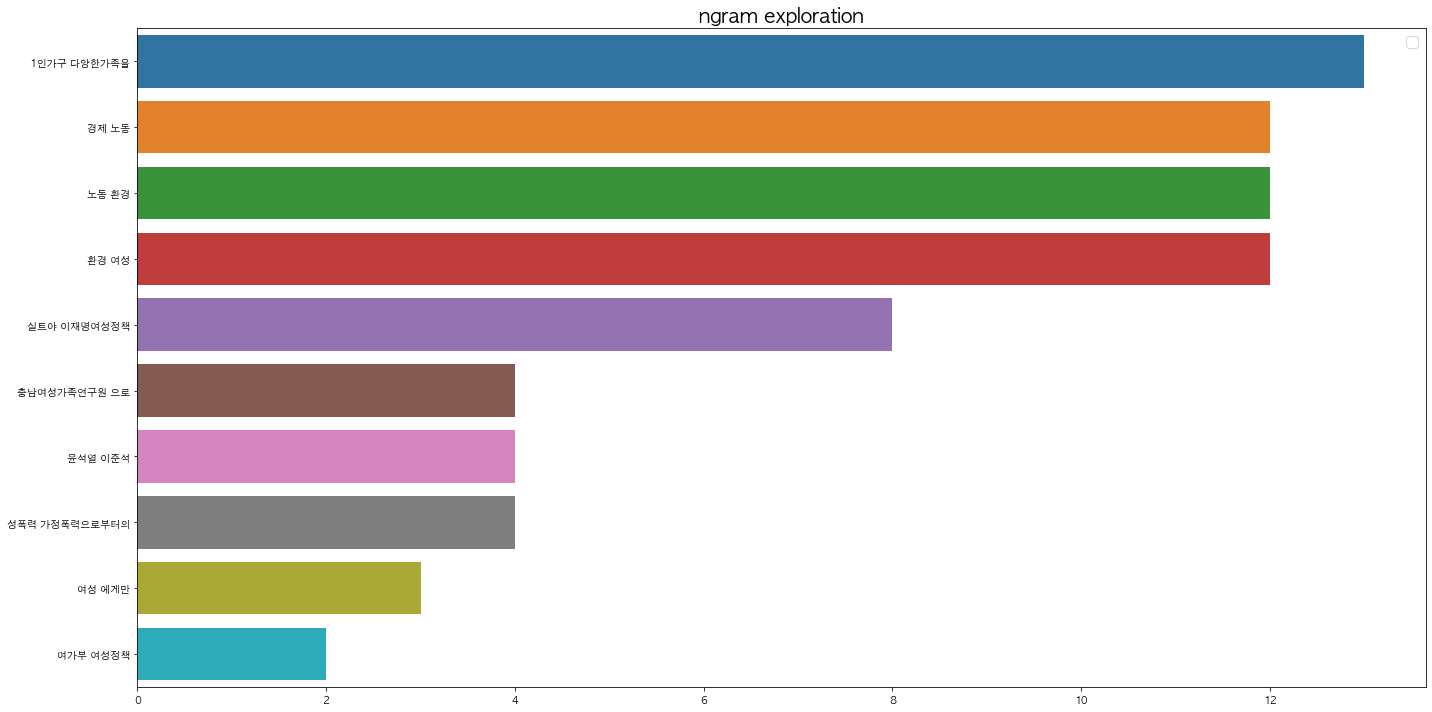

In [41]:
plt.figure(figsize=(20,10))
sns.barplot(x=y,y=x)
plt.title('ngram exploration', fontsize=20)
plt.legend(fontsize=15)
save_fig("ngram exploration")

In [47]:
nouns = women_policy['text'].swifter.apply(lambda x : okt.nouns(x))

Pandas Apply:   0%|          | 0/1128 [00:00<?, ?it/s]

In [56]:
women_policy['tokenizing']= nouns

In [74]:
women_policy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128 entries, 0 to 1127
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    1128 non-null   object
 1   id          1128 non-null   int64 
 2   text        1128 non-null   object
 3   username    1128 non-null   object
 4   tokenizing  1128 non-null   object
dtypes: int64(1), object(4)
memory usage: 85.2+ KB


In [77]:
women_policy['datetime']

0       2022-02-10 01:57:58+00:00
1       2022-02-10 03:03:04+00:00
2       2022-02-10 03:06:08+00:00
3       2022-02-10 05:03:53+00:00
4       2022-02-10 07:20:30+00:00
                  ...            
1123    2022-03-08 16:33:58+00:00
1124    2022-03-08 16:57:04+00:00
1125    2022-03-08 22:16:05+00:00
1126    2022-03-08 22:25:14+00:00
1127    2022-03-08 23:56:01+00:00
Name: datetime, Length: 1128, dtype: object

In [93]:
d = datetime.fromisoformat('2020-01-06T00:00:00.000Z'[:-1]).astimezone(timezone.utc)
d.strftime('%Y-%m-%d %H:%M:%S')

NameError: name 'timezone' is not defined

In [82]:
from datetime import datetime

In [106]:
women_policy['date'] = pd.to_datetime(women_policy['datetime']).apply(lambda x: x.date())

In [126]:
women_policy['date_re'] = women_policy['date'].apply(lambda x : x.strftime('%Y-%m-%d'))

In [250]:
date = []
word_list = []
count_list = []
# tokenizing_list = []

for i in women_policy['date_re'].unique():
    tokenizing = sum(women_policy[women_policy['date_re'] == i]['tokenizing'],[])
    c, cw = common_words(tokenizing, 1)    
    word = cw[0][0]
    count = cw[0][1]
    date.append(i)
    word_list.append(word)
    count_list.append(count)
    
dateworddict = {'date' : date, 'word' : word_list, 'count' : count_list}
test_df = pd.DataFrame(dateworddict, columns=['date', 'word', 'count'])

In [252]:
# dateworddict = {'date' : date, 'word' : word_list, 'count' : count_list}
# test_df = pd.DataFrame(dateworddict, columns=['date', 'word', 'count'])

In [299]:
def add_value_labels(ax, spacing=5):
    for idx, rect in enumerate(ax.patches):
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{0}".format(test_df['word'][idx])

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)  

No handles with labels found to put in legend.


그림 저장: most common word by date


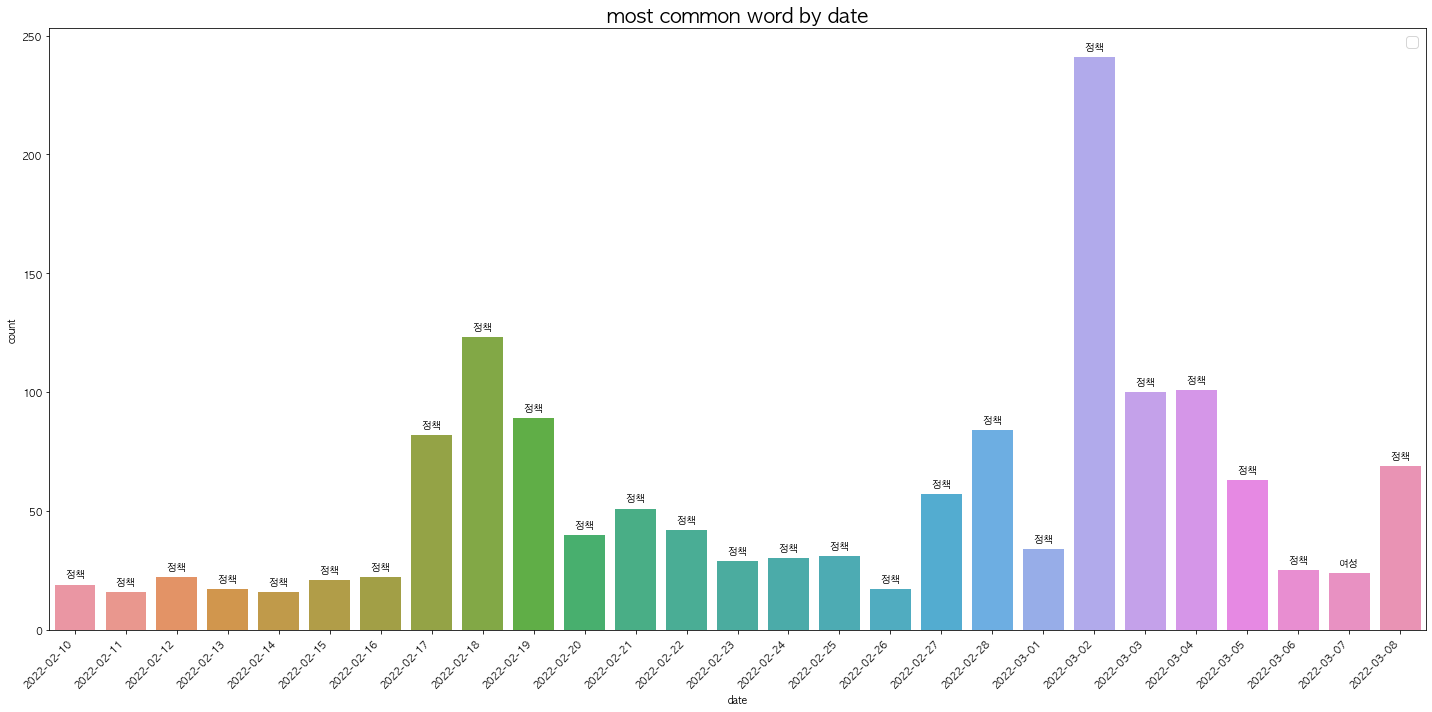

In [306]:
fig, ax = plt.subplots(1, figsize=(20,10))
plot = sns.barplot(test_df['date'], test_df['count'])
add_value_labels(ax)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('most common word by date', fontsize=20)
plt.legend(fontsize=15)
save_fig("most common word by date")

In [42]:
# topic modeling exploration with pyLDAvis

In [ ]:
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim_models

In [ ]:
corpus = []
stem = PorterStemmer()
lem = WordNetLemmatizer()
for news in text :
    words = [w for w in word_to]

In [ ]:
nouns.str.len().mean()

In [ ]:
def plot_word_number_histogram(text):
    text.str.split().map(lambda x: len(x)).hist()

In [ ]:
mecab.nouns(women_policy['text'][0])

In [ ]:
nouns = women_policy['text'].swifter.apply(lambda x : mecab.nouns(x))

In [ ]:
words_new = stopwords(words, stop_words)

In [ ]:
c, cw = common_words(words_new, 200)

In [ ]:
wordcloud(c)

In [ ]:
np.concatenate(women_policy['text'].tolist()).tolist()

In [ ]:
women_policy['text'].tolist()

In [ ]:
women_policy['text'].swifter.apply(lambda x : komoran.nouns(x))

In [ ]:
len(women_policy['text'])

In [ ]:
word_list = []
for i in range(len(women_policy['text'])):
    word = mecab.nouns(women_policy['text'][i])
    word_list.append(word)

In [ ]:
word_list = []
for i in range(15):
    word = komoran.nouns(women_policy['text'][i])
    word_list.append(word)

In [ ]:
new_word_list = np.concatenate(word_list).tolist()

In [ ]:
words = [n for n in new_word_list if len(n) > 1] 

In [ ]:
words

In [ ]:
words_new = stopwords(words, stop_words)

In [ ]:
words_new

In [ ]:
c, cw = common_words(words_new, 200)

In [ ]:
= np.concatenate(word_list).tolist()

In [ ]:
len(women_policy['text'])

In [ ]:
word = komoran.nouns(women_policy['text'][0])
word

In [ ]:
women_policy['text'][0]

In [ ]:
komoran.pos(women_policy['text'].tolist())